# Nuscenes dataset exploration

In [1]:
%matplotlib inline
from nuscenes_utils.nuscenes import NuScenes
import numpy as np
from helpers import *
nusc = NuScenes(version='v0.1', dataroot='dataset', verbose=True)

Loading NuScenes tables for version v0.1 ...
23 category,
8 attribute,
5 visibility,
6975 instance,
12 sensor,
1200 calibrated_sensor,
304715 ego_pose,
12 log,
100 scene,
3977 sample,
304715 sample_data,
99952 sample_annotation,
12 map,
Done loading in 2.6 seconds.
Reverse indexing ...
Done reverse indexing in 0.7 seconds.


## Show information on an annotation

In [25]:
#The first sample in the dataset
my_sample = nusc.sample[0] 

In [83]:
#Select a random annotation
ann_token = my_sample['anns'][2]
ann = nusc.get('sample_annotation', ann_token) 
instance = nusc.get('instance', ann['instance_token']) 
attribute = nusc.get('attribute', ann['attribute_tokens'][0])
visibility = nusc.get('visibility', ann['visibility_token'])

In [84]:
#Show an annotation
ann

{'token': 'bb09a013504d4147b405eebe0dc2daf9',
 'sample_token': 'f9878012c3f6412184c294c13ba4bac3',
 'instance_token': '7f66426f8f484b818390fe64817f97c2',
 'visibility_token': '4',
 'attribute_tokens': ['4500a0db6eee4989b14f9d75872979c1'],
 'translation': [2150.871, 615.296, 1.126],
 'size': [0.756, 1.137, 1.891],
 'rotation': [0.999998082610638, 0.0, 0.0, -0.0019582581667123315],
 'prev': '',
 'next': 'acd3847e1f964055853566fef10d959e',
 'category_name': 'human.pedestrian.adult'}

In [85]:
#Show the attribute for this annotation
attribute

{'token': '4500a0db6eee4989b14f9d75872979c1',
 'name': 'pedestrian.moving',
 'description': 'The human is moving.'}

In [86]:
#Show visibility information for this annotation
visibility

{'description': 'visibility of whole object is between 80 and 100%',
 'token': '4',
 'level': 'v80-100'}

## Different scene visualizations using nuscene provided functions

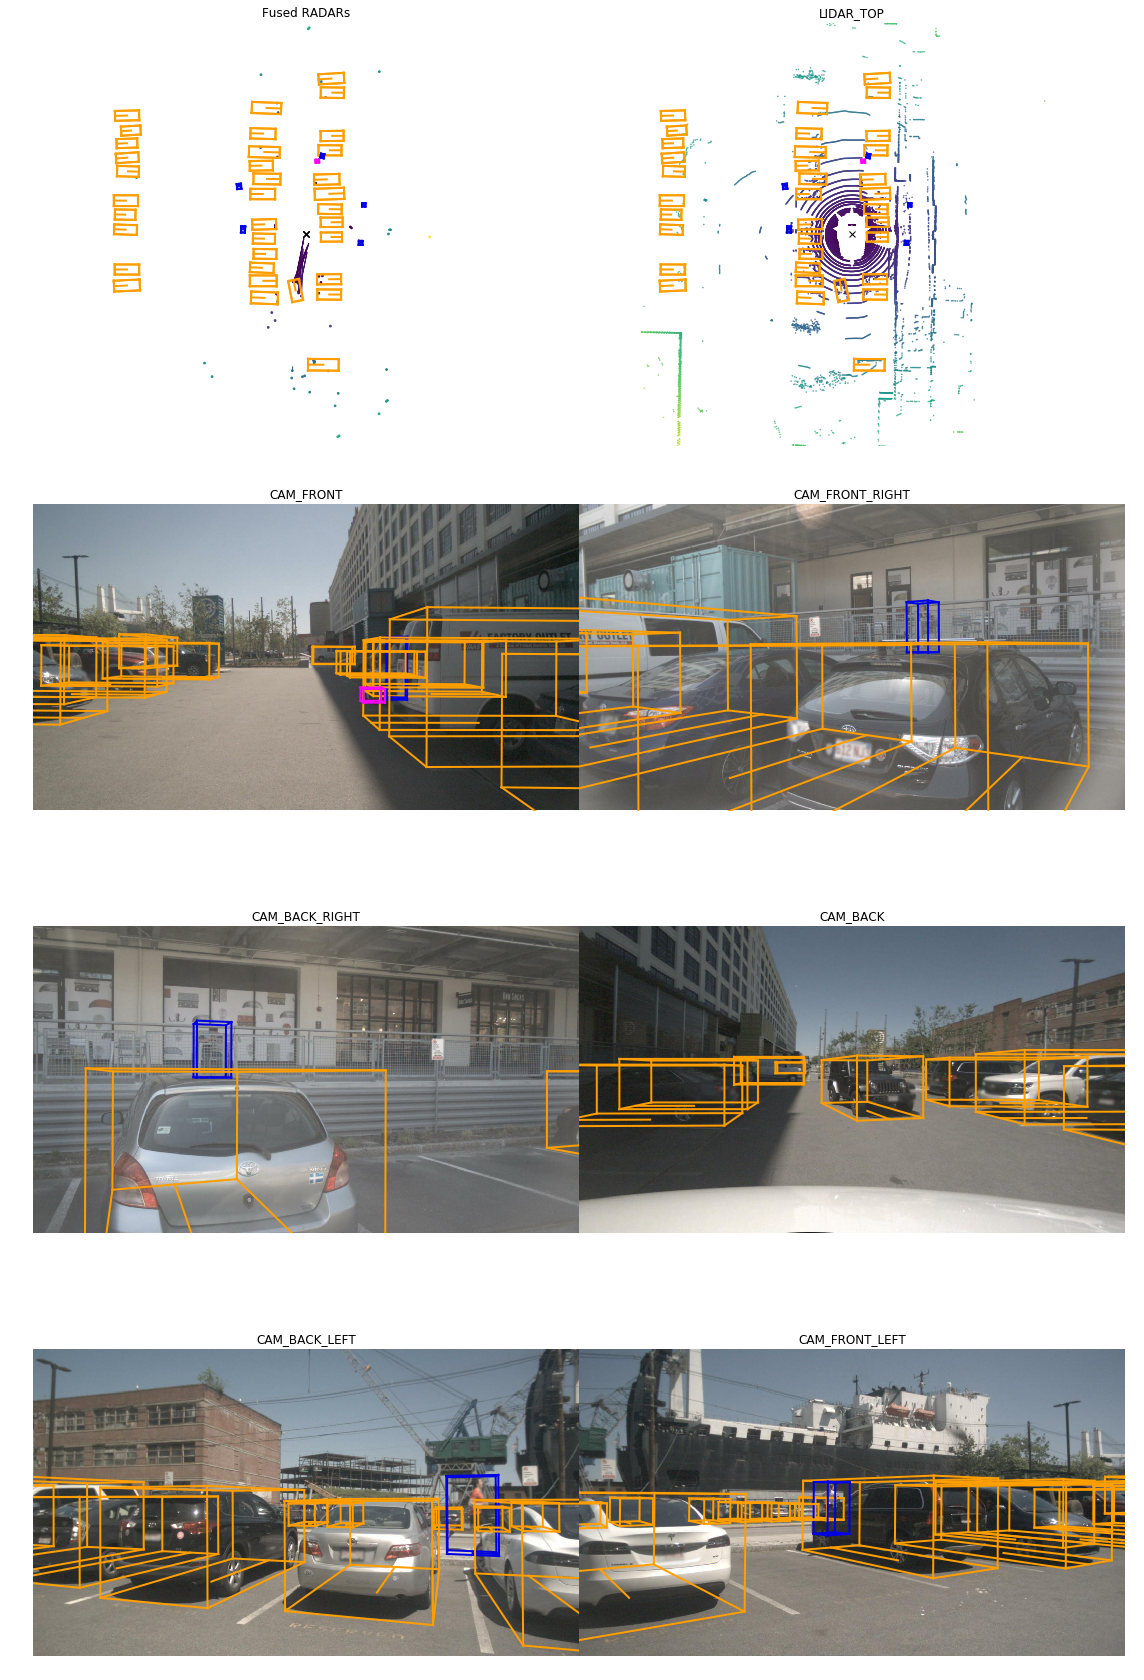

In [42]:
# We can also plot all annotations across all sample data for that sample
nusc.render_sample(my_sample['token'])

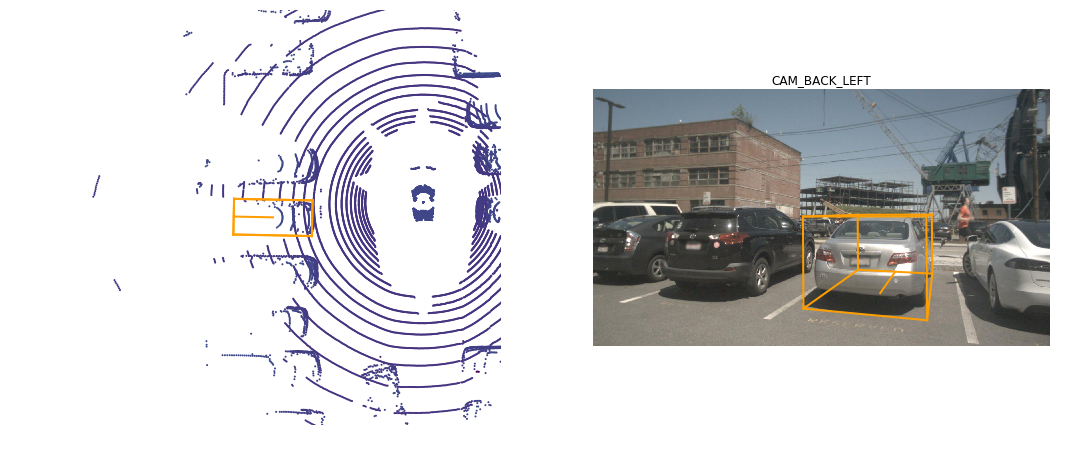

In [81]:
# We can even render a specific annotation.
# We are going to show annotation 1, which is
#the human whose annotation we showed previously
nusc.render_annotation(my_sample['anns'][12])

The category name is  human.pedestrian.adult
The attribute is: pedestrian.moving
visibility of whole object is between 80 and 100%


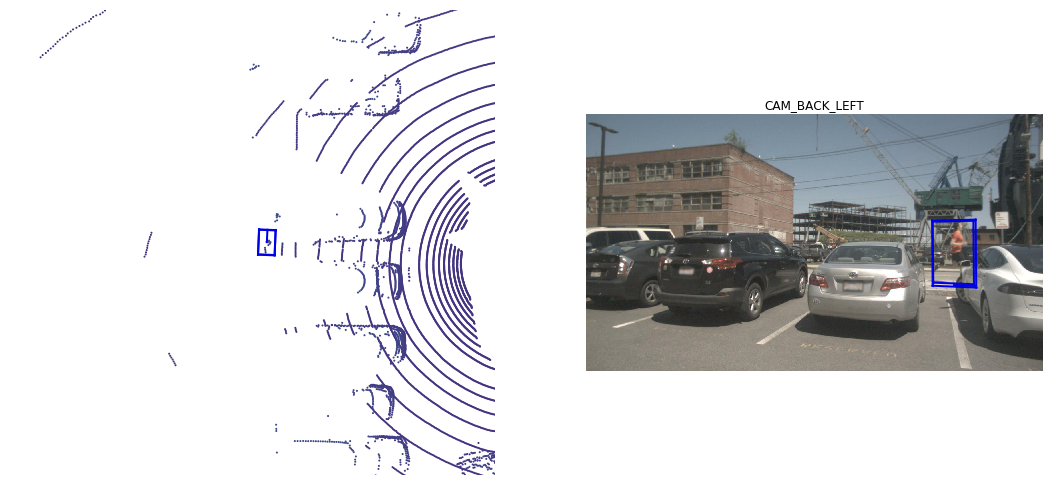

In [75]:
#Let's look at the human
ann_token = my_sample['anns'][2]
ann = nusc.get('sample_annotation', ann_token) 
instance = nusc.get('instance', ann['instance_token']) 
attribute = nusc.get('attribute', ann['attribute_tokens'][0])
visibility = nusc.get('visibility', ann['visibility_token'])
print('The category name is  '+ann['category_name'])
print('The attribute is: '+attribute['name'])
print( visibility['description'])
nusc.render_annotation(ann_token)

The category name is  vehicle.car
The attribute is: vehicle.parked
visibility of whole object is between 80 and 100%


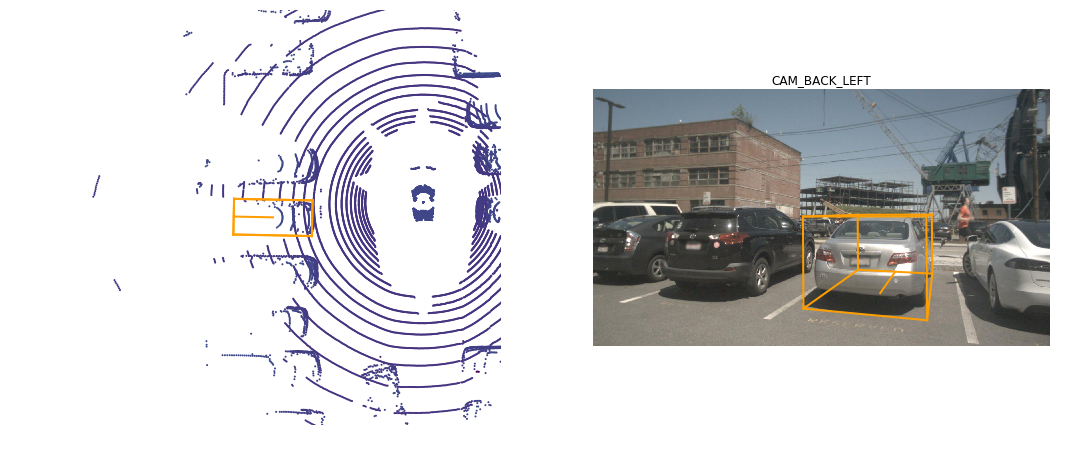

In [82]:
#Let's look at another example (a vehicle)
ann_token = my_sample['anns'][12]
ann = nusc.get('sample_annotation', ann_token) 
instance = nusc.get('instance', ann['instance_token']) 
attribute = nusc.get('attribute', ann['attribute_tokens'][0])
visibility = nusc.get('visibility', ann['visibility_token'])
print('The category name is  '+ann['category_name'])
print('The attribute is: '+attribute['name'])
print( visibility['description'])
nusc.render_annotation(ann_token)

## Exploration of trajectories in the dataset: how annotations are moving?
## How many trajectories do we consider outliers?

In [20]:
#We load the trajectory data using functions in helpers.py
map_data_all = load_traj_data(nusc, only_vehicles = True)

In [21]:
#Split data in chunks of 7 seconds each using the function in helpers.py
#SPLIT_DATA
fs = 2
split_size = 7*fs #samples
step = 4*fs #samples

#MAP_DATA_SPLIT saves the data in the dataset and is a list of scenes x partitions x instances x time_steps x 2.
#Last 3 dimensions are kept in a numpy array
map_data_split = np.array(split_data(split_size, step, map_data_all))

In [94]:
#minimun length for a trajectory to be considered not stopped.
THRESHOLD_LENGTH = 10
THRESHOLD_ACCELERATION = 25

instance_ID = 0
ins_offset = 0

#PART_NO is a dictionary that associates an instance ID to the number of trajectories (partitions)
#that this instance has in MAP_DATA_SPLIT
part_no = {}

#number of outliers
outliers = 0

for scene_ix in range(map_data_split.shape[0]):
    traj_partitions = []
    for partition_ix in range(len(map_data_split[scene_ix])):
        part = map_data_split[scene_ix][partition_ix]
        traj_instances= []
    
        for instance_ix in range(part.shape[0]):
            instance_ID = ins_offset + instance_ix
            traj = map_data_split[scene_ix][partition_ix][instance_ix]
            traj_x = traj[:, 0]
            traj_y = traj[:, 1]

            #If any value in the trajectory is -999 then that trajectory is not complete 
            #and is discarded
            if(~np.any(traj_x == -999) and ~np.any(traj_y == -999)):

                #If the length is greater than the threshold we consider the vehhicle to not
                #be stopped
                if(get_length(traj)>THRESHOLD_LENGTH):
                    #If the max of the acceleration is above a certain threshold, we consider
                    #this trajectory to be an outlier
                    vel2D = np.diff(traj, 1, axis = 0)
                    vel1D = np.sqrt(np.power(vel2D[:,0],2) + np.power(vel2D[:,1],2))
                    a = np.abs(np.diff(vel1D))
                    if(np.max(a) > THRESHOLD_ACCELERATION):
                        outliers = outliers + 1

                    if instance_ID not in part_no: 
                        part_no[instance_ID]= 0
                    part_no[instance_ID]+=1
        
    ins_offset = instance_ID+1

print('The number of unique, longer than 10 pixels, trajectories in the dataset is: ', len(part_no))
print('The number of chunks of a trajectory of 7 seconds with step between them 4 seconds is: ', sum(part_no.values()))
print('Of them, we consider outliers: ', outliers)
print('The average number of chunks a trajectory produces is: ', np.mean(list(part_no.values())))

The number of unique, longer than 10 pixels, trajectories in the dataset is:  367
The number of chunks of a trajectory of 7 seconds with step between them 4 seconds is:  912
Of them, we consider outliers:  67
The average number of chunks a trajectory produces is:  2.4850136239782015


## Let's plot this trajectories. We also load pedestrian data

In [101]:
map_data_all = load_traj_data(nusc, only_vehicles = False)
map_data_split = np.array(split_data(split_size, step, map_data_all))

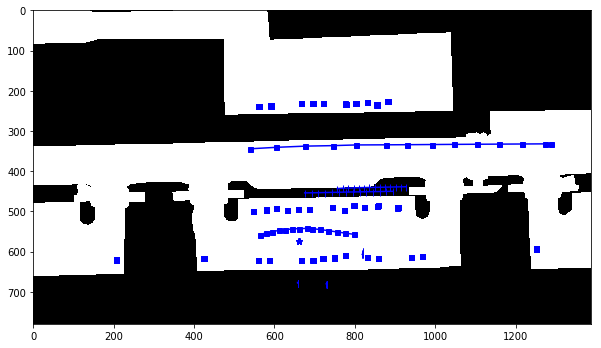

In [104]:
#The scene is quite crowded, but lot of the annotations are static ones. 
#Pedestrians are represented as bars and vehicles as squares. 
#The position of the ego vehicle is represented as a star.
#7 seconds of a scene are plotted.
#Annotations that are neither vehicles nor pedestrians are not plotted.

#Points that are connected to each other belong in the same trajectory,
#points that aren't represent different instances.
scene_i = 0
scenes = nusc.scene
record = scenes[scene_i]
partition = map_data_split[scene_i][0]
instance_tokens = map_data_all[scene_i]['instance_tokens'] #extra index is not useful
plot_1traj_partition(nusc, record, partition, instance_tokens)


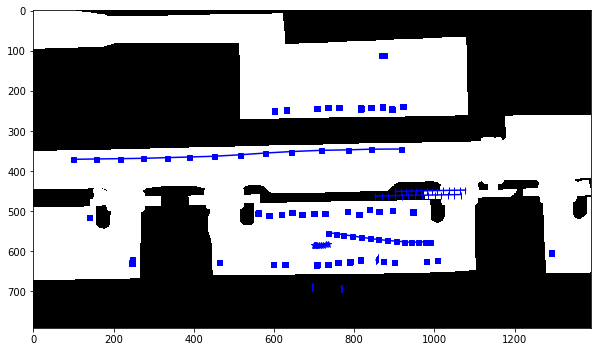

In [156]:
#We now plot the next partition for the following scene
scene_i = 0
scenes = nusc.scene
record = scenes[scene_i]
partition = map_data_split[scene_i][1]
instance_tokens = map_data_all[scene_i]['instance_tokens'] #extra index is not useful
plot_1traj_partition(nusc, record, partition, instance_tokens)

The maximum acceleration in the trajectory is  63.69886383813378
It is therefore considered an outlier


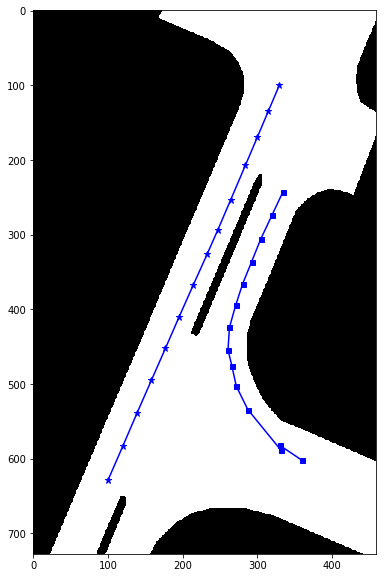

In [155]:
#Now we plot only two trajectories on the map: 
#That of the ego vehicle and a trajectory
#that we consider outlier
scene_i = 90
scenes = nusc.scene
record = scenes[scene_i]
partition = map_data_split[scene_i][0][0:2]
instance_tokens = map_data_all[scene_i]['instance_tokens'][0:2] #extra index is not useful
plot_1traj_partition(nusc, record, partition, instance_tokens)

#Find the maximum instantenous acceleration in the 
#outlier trajectory
traj = partition = map_data_split[scene_i][0][1]
vel2D = np.diff(traj, 1, axis = 0)
vel1D = np.sqrt(np.power(vel2D[:,0],2) + np.power(vel2D[:,1],2))
a_ = np.abs(np.diff(vel1D))
print('The maximum acceleration in the trajectory is ', max(a_))
print('It is therefore considered an outlier')

## Spatial LSTM Trajectory prediction results visualization

In [2]:
spatial_predicted = np.load('data/spatial_predicted.npy')
spatial_info = np.load('data/spatial_info.npy')

In [5]:
#The test set in the simulated dataset contains 328 trajectories.
spatial_predicted.shape

(328, 13, 2)

In [18]:
index

[2, 0, 33]

In [3]:
#load the simulated and the real nuscenes trajectories 
#load the simulated trajectories
map_data_split_real = np.load('data/map_data_split14.npy')  #scenes x partitions x instances x time_steps x 2
map_data_split = np.load('data/all_trajs_generated.npy')  #scenes x partitions x instances x time_steps x 2
map_data_split = np.array([[np.array(map_data_split[i])] for i in range(100)])

In [4]:
#Find offset in the generated trajs
#Find the limits of the scene
def find_offset(partition):
    xmin = 1000000
    ymin = 1000000
    for i in range(partition.shape[1]):
        indexes = np.where(partition[:,i,0] != -999)[0]
        for instance_index in indexes:
            x = partition[instance_index][i][0]
            y = partition[instance_index][i][1]
            xmin = min(xmin,x) 
            ymin = min(ymin,y)
    return xmin - 500, ymin- 500


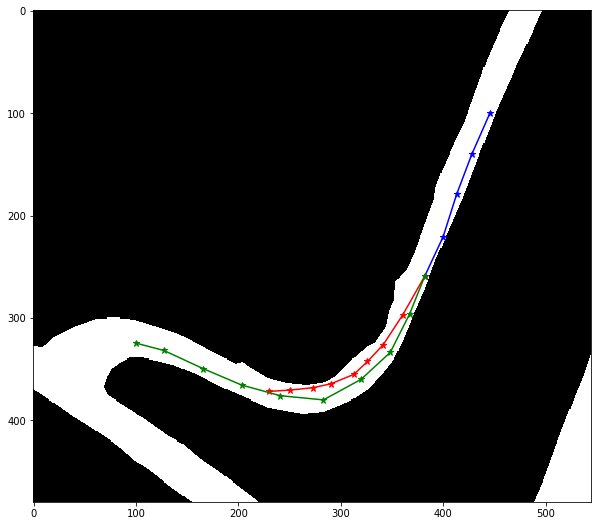

In [5]:
#PLOT A FEW EXAMPLES OF SPATIAL LSTM PREDICTION.
#IN GREEN, THE TRUE TRAJECTORY. IN RED, THE PREDICTED 
#BY LSTM TRAJECTORY

#index of the trajectory we want to see on the map
i = 126

traj_pred = spatial_predicted[i]
index = spatial_info[i][2]
scene_i = index[0]+90
traj_real = map_data_split[scene_i][index[1]][index[2]]
#We now plot the next partition for the following scene
offx, offy = find_offset(map_data_split_real[scene_i][0])

traj_pred[:,0] += offy
traj_pred[:,1]+= offx
traj_real[:,0] += offy
traj_real[:,1]+= offx

scene_i = index[0]+90
scenes = nusc.scene
record = scenes[scene_i]
plot_2traj_partition(nusc, record, np.expand_dims(traj_real,axis = 0), np.expand_dims(traj_pred,axis = 0))
#plot_2traj_partition(nusc, record, np.expand_dims(traj_real,axis = 0), np.expand_dims(traj_pred,axis = 0))

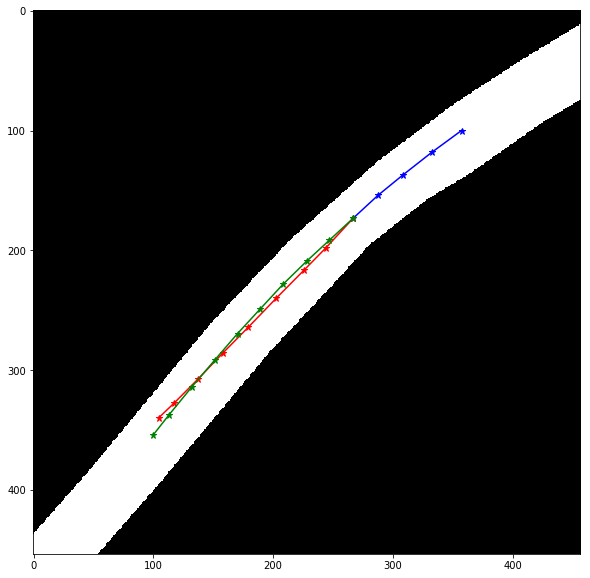

In [6]:
#PLOT A FEW EXAMPLES OF SPATIAL LSTM PREDICTION.
#IN GREEN, THE TRUE TRAJECTORY. IN RED, THE PREDICTED 
#BY LSTM TRAJECTORY

#index of the trajectory we want to see on the map
i = 162

traj_pred = spatial_predicted[i]
index = spatial_info[i][2]
scene_i = index[0]+90
traj_real = map_data_split[scene_i][index[1]][index[2]]
#We now plot the next partition for the following scene
offx, offy = find_offset(map_data_split_real[scene_i][0])

traj_pred[:,0] += offy
traj_pred[:,1]+= offx
traj_real[:,0] += offy
traj_real[:,1]+= offx

scene_i = index[0]+90
scenes = nusc.scene
record = scenes[scene_i]
plot_2traj_partition(nusc, record, np.expand_dims(traj_real,axis = 0), np.expand_dims(traj_pred,axis = 0))
#plot_2traj_partition(nusc, record, np.expand_dims(traj_real,axis = 0), np.expand_dims(traj_pred,axis = 0))

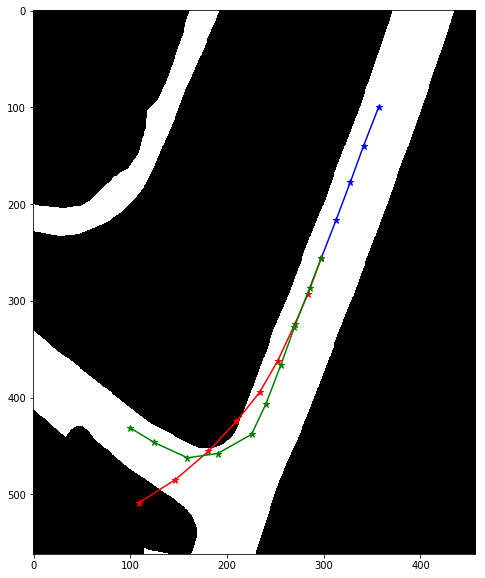

In [7]:
#PLOT A FEW EXAMPLES OF SPATIAL LSTM PREDICTION.
#IN GREEN, THE TRUE TRAJECTORY. IN RED, THE PREDICTED 
#BY SPATIAL LSTM TRAJECTORY

#index of the trajectory we want to see on the map
i = 269
traj_pred = spatial_predicted[i]
index = spatial_info[i][2]
scene_i = index[0]+90
traj_real = map_data_split[scene_i][index[1]][index[2]]
#We now plot the next partition for the following scene
offx, offy = find_offset(map_data_split_real[scene_i][0])

traj_pred[:,0] += offy
traj_pred[:,1]+= offx
traj_real[:,0] += offy
traj_real[:,1]+= offx

scene_i = index[0]+90
scenes = nusc.scene
record = scenes[scene_i]
plot_2traj_partition(nusc, record, np.expand_dims(traj_real,axis = 0), np.expand_dims(traj_pred,axis = 0))
#plot_2traj_partition(nusc, record, np.expand_dims(traj_real,axis = 0), np.expand_dims(traj_pred,axis = 0))

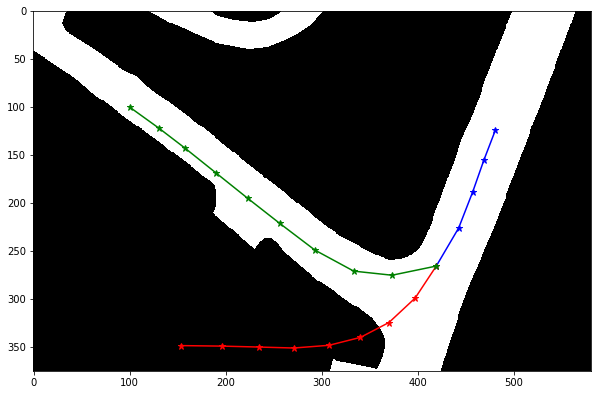

In [8]:
#PLOT A FEW EXAMPLES OF SPATIAL LSTM PREDICTION.
#IN GREEN, THE TRUE TRAJECTORY. IN RED, THE PREDICTED 
#BY LSTM TRAJECTORY
#index of the trajectory we want to see on the map
i = 272

traj_pred = spatial_predicted[i]
index = spatial_info[i][2]
scene_i = index[0]+90
traj_real = map_data_split[scene_i][index[1]][index[2]]
#We now plot the next partition for the following scene
offx, offy = find_offset(map_data_split_real[scene_i][0])

traj_pred[:,0] += offy
traj_pred[:,1]+= offx
traj_real[:,0] += offy
traj_real[:,1]+= offx

scene_i = index[0]+90
scenes = nusc.scene
record = scenes[scene_i]
plot_2traj_partition(nusc, record, np.expand_dims(traj_real,axis = 0), np.expand_dims(traj_pred,axis = 0))
#plot_2traj_partition(nusc, record, np.expand_dims(traj_real,axis = 0), np.expand_dims(traj_pred,axis = 0))

## Example of trajectory generation in a scene

In [1]:
from simTrajHelpers import *

Loading NuScenes tables for version v0.1 ...
23 category,
8 attribute,
5 visibility,
6975 instance,
12 sensor,
1200 calibrated_sensor,
304715 ego_pose,
12 log,
100 scene,
3977 sample,
304715 sample_data,
99952 sample_annotation,
12 map,
Done loading in 2.8 seconds.
Reverse indexing ...
Done reverse indexing in 0.7 seconds.


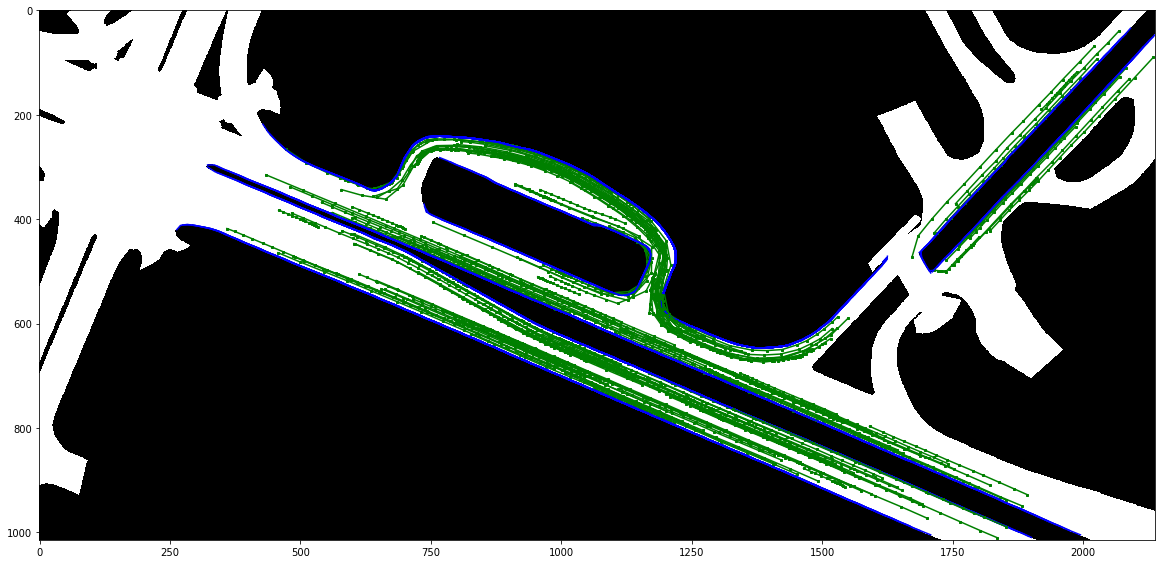

In [2]:
#In green the synthesized trajectories. In blue the edge between the drivable and non-drivable
#areas that this trajectories follow.

delta = 500
scene_ix = 50
trajs, do = get_lines(scene_ix, delta)
trajs_div = divide_trajs(trajs)
new_trajs = get_new_trajs(trajs_div,do, test = False, show = True)